In [20]:
code_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/code"
import os, sys
if code_dir not in sys.path:
    sys.path.append(code_dir)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pyopengv
import numpy as np
import matplotlib.pyplot as plt
from shutil import copyfile
from tqdm import tqdm

from utilis.utilis import crop_image
from pose.get_pose import *

## Load data

In [4]:
coord_data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_full/"
model_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/experiments/2021-04-18/full_run_world_coord_2021-04-18_10:56:51/model_checkpoint"
experiment_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/experiments/2021-04-18/full_run_world_coord_2021-04-18_12:02:26"

In [5]:
image_ind = 100
coord_npz = f"{image_ind:04}_rendered.png_config.npz"
npz_data = np.load(coord_data_dir + coord_npz)
    
image = npz_data['image_colors']
scene_coords = npz_data['points_3d_world']
pixel_bearings = npz_data['points_3d_sphere']

## Get pose

In [6]:
# evaluate_pose(model_dir, experiment_dir, image, scene_coords, pixel_bearings)

In [11]:
code_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/code"
import os, sys
if code_dir not in sys.path:
    sys.path.append(code_dir)

import pyopengv
import numpy as np
import matplotlib.pyplot as plt
from shutil import copyfile

from tensorflow import keras
from utilis.utilis import *




def get_random_points(n):
    samples = np.zeros((n,2), dtype=int)
    sample_set = set()
    i = 0
    while i < n :
        sample = np.random.randint(224, size=2)
        if str(sample) not in sample_set:
            samples[i] = sample
            sample_set.add(str(sample))
            i += 1
    
    return samples


def get_pose(scene_coordinates, pixel_bearings, n=10, threshold=0.004):
    """ 
    Applies openGV PnP solver and gets T and R   
    """
    # get n randomly selected pixel coordiates
    samples = get_random_points(n)

    bs = pixel_bearings[samples[:,0], samples[:,1], :]
    Xs = scene_coordinates[samples[:,0], samples[:,1], :]

    T_full = pyopengv.absolute_pose_lmeds(bs, Xs, "EPNP", 1- np.cos(threshold), 1000)
    R = T_full[:, :3]
    T = T_full[:, 3]

    pose = {'T': T, 'R': R}
    return pose


def get_pose_all_points(scene_coordinates, pixel_bearings, threshold=0.004):
    """ 
    Applies openGV PnP solver and gets T and R   
    """
    T_full = pyopengv.absolute_pose_lmeds(pixel_bearings, scene_coordinates, "EPNP", 1- np.cos(threshold), 1000)
    R = T_full[:, :3]
    T = T_full[:, 3]

    pose = {'T': T, 'R': R}
    return pose


def get_pose_error(pred_pose, true_pose):
    " evaluates quality of pose estiamtion - need to look up how this is calculated "
    # location error - euclidean disance between predicted and true camera centers in units (not sure if meters)
    loc_error = np.linalg.norm( true_pose['T'] - pred_pose['T'] )

    # orientation error - angle error in degrees
    # solution as presented here: https://math.stackexchange.com/questions/2113634/comparing-two-rotation-matrices
    true_R_T = np.transpose(true_pose['R'])
    rotation_ab = np.matmul(true_R_T, pred_pose['R'])
    orient_error = np.rad2deg(np.arccos((np.trace(rotation_ab) - 1) / 2))

    return orient_error, loc_error


def get_camera_points(R, T, scale=1, color=None):
    num_points = int(scale * 100)
    origin_vertices = scale * np.array([[0,1,1],
           [1,0,1],
           [0,-1,1],
           [-1,0,1]])

    origin_camera_center = np.array([0,0,0])
    
    camera_center = np.matmul(origin_camera_center, R) + T
    vertices = np.matmul(origin_vertices, R) + T
    
    # CAMERA FIELD
    pose_vertices = []
    for i in [-1,0,1,2]:
        new_vertices = np.array([vertices[i] + (float(n)/num_points)*(vertices[i+1] - vertices[i]) for n in range(num_points)])
        if len(pose_vertices) == 0:
            pose_vertices = new_vertices
        else:
            pose_vertices = np.concatenate((pose_vertices, new_vertices), axis=0)

    # LINES TO CAMERA CENTER
    for i in [0,1,2,3]:
        new_vertices = np.array([vertices[i] + (float(n)/num_points)*(camera_center - vertices[i]) for n in range(num_points)])
        pose_vertices = np.concatenate((pose_vertices, new_vertices), axis=0)

    # COLORS
    if color == "blue":
        colors = np.array([[0,0,255]]*len(pose_vertices))
    elif color == "green":
        colors = np.array([[0,255,0]]*len(pose_vertices))
    else:
        colors = np.array([[255,0,0]]*len(pose_vertices))

    
    return pose_vertices, colors, camera_center


def get_line_points(first_point, second_point):
    num_points = int(30 * np.mean(np.abs(second_point - first_point)))
    vertices = np.array([first_point + (float(n)/num_points)*(second_point - first_point) for n in range(num_points)])
    colors = np.array([[255,0,0]]*len(vertices))

    return vertices, colors


def save_ply_file(experiment_dir, pred_pose, true_pose, ground_truth_coords, image):

    # get camera points
    pred_camera_points, pred_camera_colors, pred_camera_center = get_camera_points(pred_pose['R'], pred_pose['T'], scale=0.2, color="blue")
    true_camera_points, true_camera_colors, true_camera_center = get_camera_points(true_pose['R'], true_pose['T'], scale=0.2, color="green")
    error_line_points, error_line_colors = get_line_points(pred_camera_center, true_camera_center)

    # make folder in exp directory 
    ply_exp_dir = experiment_dir + "/pose/"
    if not os.path.exists(ply_exp_dir):
        os.makedirs(ply_exp_dir)

    # write files
    writePlyFile(ply_exp_dir, "pred_camera.ply", pred_camera_points, pred_camera_colors)
    writePlyFile(ply_exp_dir, "true_camera.ply", true_camera_points, true_camera_colors)
    writePlyFile(ply_exp_dir, "error_line.ply", error_line_points, error_line_colors)
    writePlyFile(ply_exp_dir, "ground_truth_3D.ply", ground_truth_coords, image)

In [ ]:
#     origin_vertices = scale * np.array([[-2,0,1,],
#        [-2,1,0],
#        [-2,0,-1],
#        [-2,-1,0]])
#     origin_vertices = scale * np.array([[1,-2,0],
#        [0,-2,1],
#        [-1,-2,0],
#        [0,-2,-1]])

In [12]:
model_dir, experiment_dir, image, gt_scene_coords, bearing = model_dir, experiment_dir, image, scene_coords, pixel_bearings

In [13]:
# get model
print("Loading model ...")
model = keras.models.load_model(model_dir)

Loading model ...


In [14]:
image_ind = 120
coord_npz = f"{image_ind:04}_rendered.png_config.npz"
npz_data = np.load(coord_data_dir + coord_npz)
    
image = npz_data['image_colors']
scene_coords = npz_data['points_3d_world']
pixel_bearings = npz_data['points_3d_sphere']

In [15]:
# crop image
image, gt_scene_coords, bearing = crop_image(image, scene_coords, pixel_bearings, (256,512))
image = np.expand_dims(image, axis=0)

In [16]:
# model predicts scene_coords
print("Predict Scene Coordinates ...")
pred_scene_coords = model.predict(image)

Predict Scene Coordinates ...


In [17]:
# get T and R of a camera
pred_pose = get_pose(pred_scene_coords[0], bearing, n=10, threshold=0.004)
true_pose = get_pose(gt_scene_coords, bearing, n=10, threshold=0.004)
print("TRUE pose:   ", pred_pose, "\n")
print("PRED pose:   ", true_pose, "\n\n")

TRUE pose:    {'T': array([ 6.80236285, 18.24178625, -2.57202835]), 'R': array([[ 0.83226502,  0.11907157,  0.54143965],
       [ 0.43313489, -0.74925308, -0.50101295],
       [ 0.34601893,  0.65149196, -0.67515119]])} 

PRED pose:    {'T': array([ 4.8798649 , 17.82508253, -1.55127303]), 'R': array([[ 0.96327567,  0.16975673,  0.20804478],
       [ 0.23567488, -0.16321685, -0.95802798],
       [-0.12867528,  0.97187598, -0.19723022]])} 




In [18]:
# compute pose error
orient_error, loc_error = get_pose_error(pred_pose, true_pose)
print("Location error:   ", loc_error)
print("Orientation error:   ", orient_error)

Location error:    2.2162088753475695
Orientation error:    47.12832674751239


In [36]:
# visualise pose
save_ply_file(experiment_dir, pred_pose, true_pose, gt_scene_coords, image)

# Experiment with number of points for EPnP 

In [26]:
loc_errors = []
orient_errors = []

for n in tqdm([10,20,30,40,50]): # EPnP needs at least 6 points
    mean_loc = 0
    mean_orient = 0
    num = 20
    
    for i in range(num):
        # get T and R of a camera
        pred_pose = get_pose(pred_scene_coords[0], bearing, n=n, threshold=0.004)
        true_pose = get_pose(gt_scene_coords, bearing, n=n, threshold=0.004)

        orient_error, loc_error = get_pose_error(pred_pose, true_pose)
        mean_loc += loc_error
        mean_orient += orient_error
    
    loc_errors.append(mean_loc/num)
    orient_errors.append(mean_orient/num)

100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


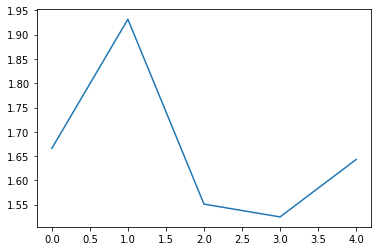

In [27]:
plt.plot(np.arange(len(loc_errors)), loc_errors)

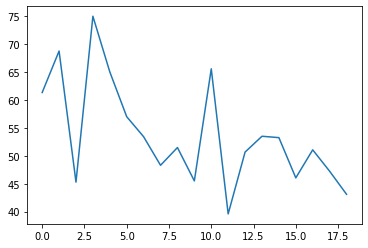

In [25]:
plt.plot(np.arange(len(orient_errors)), orient_errors)